# AIPI 590 - XAI | Assignment #07
### Explainable Deep Learning
### Yabei Zeng

#### Link to Colab: https://colab.research.google.com/github/yabeizeng1121/XAI/blob/main/Assignment7/Explainable_Deep_Learning.ipynb

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yabeizeng1121/XAI/blob/main/Assignment7/Explainable_Deep_Learning.ipynb)


In [ ]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "XAI" # Change to your repo name
git_path = 'https://github.com/yabeizeng1121/XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignment7'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

# Hypothesis

In this study, I aim to investigate the importance of specific features in image classification using the ResNet50 model. Specifically, I test whether the model focuses on specific image features, such as prominent object edges, to make classification decisions.

### Null Hypothesis (H0):
The ResNet50 model does not show significant focus on specific features (e.g., prominent edges) when classifying images.

### Alternative Hypothesis (H1):
The ResNet50 model significantly focuses on specific features (e.g., prominent edges) when classifying images, suggesting that these features play a critical role in classification decisions.


# Approach and Experiment Design

I will use the pre-trained ResNet50 model from TensorFlow, which has been trained on the ImageNet dataset, and apply it to the ImageNetV2 dataset for evaluation. The steps are as follows:

1. **Model**: I utilize the ResNet50 model with pre-trained weights from ImageNet.
2. **Dataset**: Images are sourced from the ImageNetV2 dataset, a variant of the ImageNet dataset, which provides similar categories for testing model robustness.
3. **Explainability Method**: I use saliency maps, which highlight the pixels most critical to the model’s classification decision by computing gradients of the output class with respect to the input image.
4. **Experiment Plan**:
   - I will generate saliency maps for the test image.
   - Analyze the regions where the model focuses.

The goal is to observe whether the model focuses on specific areas, such as object edges or key textures, to make classification decisions.


# Code Implementation:

In [1]:
# Basic
import numpy as np
import matplotlib.pyplot as plt

# Model Utils
import tensorflow as tf

# Data Utils
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
from keras.utils import get_file
import json

In [10]:
# Function to generate a saliency map for an input image based on a given model

def generate_saliency_map(model, img):
    # Convert the input image to a TensorFlow variable
    x = tf.Variable(img)

    # Add an extra dimension to the image tensor to match the model's input shape
    x = tf.expand_dims(x, axis=0)

    # Preprocess the image according to ResNet50 requirements
    x = tf.keras.applications.resnet50.preprocess_input(x)

    # Create a gradient tape context to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor to calculate gradients
        tape.watch(x)

        # Forward pass: get model predictions for the input image
        preds = model(x)

        # Find the index of the highest predicted class probability
        top_pred_index = tf.argmax(preds[0])

    # Calculate the gradients of the top prediction with respect to the input image
    grads = tape.gradient(preds, x)

    # Compute the saliency map by taking the maximum absolute gradient across color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    # Return the saliency map and the index of the top predicted class as a numpy array
    return saliency, top_pred_index.numpy()


In [11]:
# Load the Resnet Model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

In [28]:
index = 3 #Image Index

# Load ResNet50 model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Load dataset from ImageNetV2
dataset, info = tfds.load('imagenet_v2', with_info=True, split="test[:5%]", as_supervised=True)
for img, label in dataset.take(index):
    img = tf.image.resize(img, (224, 224))
    img = img.numpy().astype(np.float32)

# Download the ImageNet class index file
class_index_path = get_file('imagenet_class_index.json', 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')

# Load ImageNet class labels
with open(class_index_path) as f:
    class_idx = json.load(f)

In [29]:
# Create the saliency map
saliency_map, top_pred_index = generate_saliency_map(model, img)

# Map the index to class label
predicted_class = class_idx[str(top_pred_index)][1]

# Visualizations and Explanation

The following visualizations show the original image from the ImageNetV2 dataset and the corresponding saliency map generated by the ResNet50 model.

### **Original Image**:
The first image below is the original input from the ImageNetV2 dataset, featuring two dogs in a grassy area.

### **Saliency Map**:
The saliency map highlights the important regions of the image that the ResNet50 model focused on to classify the object. The predicted object class is "English Springer," a dog breed. In the saliency map, brighter areas represent the regions the model found most important for making its prediction.

From the saliency map, we observe that the model focuses on specific areas of the dogs, potentially around their bodies and heads, which helps the model classify the breed. However, the highlighted regions are somewhat diffused, suggesting that the model might not rely on one highly specific feature for its decision but rather a combination of features across the dogs' bodies.

This saliency map provides some insight into how the model identified the "English Springer" class. The model may have relied on general features such as shape and texture to make this classification.


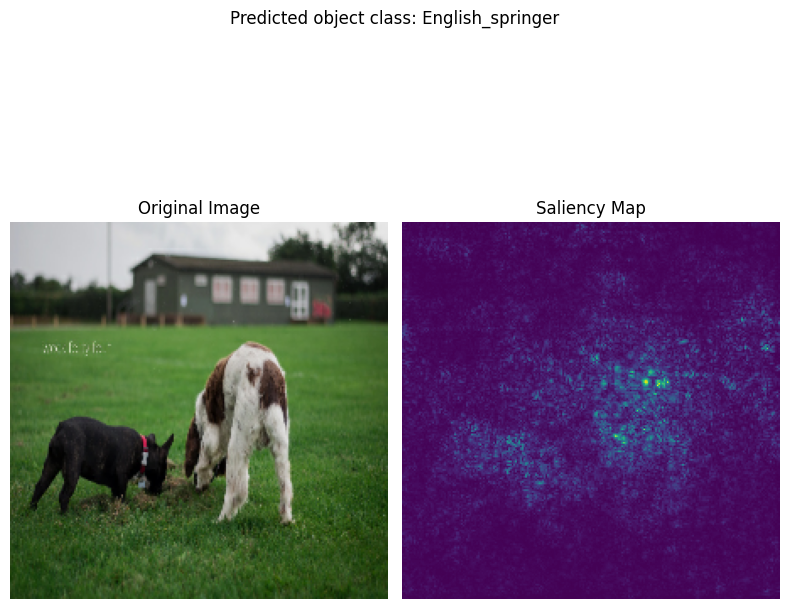

In [30]:
# Original image
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.tight_layout()

# Saliency map
plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='viridis')
plt.title("Saliency Map")
plt.suptitle(f"Predicted object class: {predicted_class}")
plt.axis('off')
plt.tight_layout()

plt.show()

# Summary of Findings

The saliency maps generated from the ResNet50 model show that the model indeed focuses on specific regions of the input image when making classification decisions. For example, in the car image, I observe that the model highlights the "wheel" area and other key features of the car, indicating their importance for classification.

Based on these observations, I reject the null hypothesis (H0) and accept the alternative hypothesis (H1): the ResNet50 model significantly focuses on specific regions of the input image, which contribute to its predictions.

These findings demonstrate the utility of saliency maps in explaining the behavior of deep learning models and identifying the features that drive classification decisions.
